In [1]:
## importamos todas las funciones de la clase 3
from option_pricing import opcion_europea_bs, opcion_americana_bin, opcion_europea_bin, opcion_europea_bin_c
import option_data as od
import yfinance as yf
import numpy as np
from scipy import interpolate
from matplotlib import pyplot as plt

In [2]:
## vamos a comparar un call priceado por black and scholes contra un call priceado por arbol binomial

tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma =0.25
div = 0


pasos = 5000
precio_bin = opcion_europea_bin(tipo, S, K, T, r, sigma, div,pasos)
precio_bs = opcion_europea_bs(tipo, S, K, T, r, sigma, div)

print("Precio de Black Scholes : ", precio_bs)
print("Precio Modelo Binomial  : ", precio_bin)

Precio de Black Scholes :  12.335998930368717
Precio Modelo Binomial  :  12.33550453323051


In [3]:
##  comparacion con el mercado:

ticker = 'TSLA'
panel_nyse = od.generar_df_opciones(ticker)
panel_nyse = od.get_full_data(panel_nyse)

In [4]:
#Me quedo con una parte pequeña del panel

panel_nyse = panel_nyse[panel_nyse.TTM<100]
panel_nyse = panel_nyse[panel_nyse.Moneyness>=0.8]
panel_nyse = panel_nyse[panel_nyse.Moneyness<=1.2]

panel_nyse

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Bid,Ask,impliedVolatility,Moneyness
30,TSLA210813C00595000,TSLA,709.98999,C,595.0,3,114.00,114.75,115.75,0.769045,1.193260
31,TSLA210813C00600000,TSLA,709.98999,C,600.0,3,110.15,109.65,110.75,0.715823,1.183317
32,TSLA210813C00605000,TSLA,709.98999,C,605.0,3,105.32,104.65,105.75,0.684573,1.173537
33,TSLA210813C00610000,TSLA,709.98999,C,610.0,3,100.25,99.85,100.80,0.699222,1.163918
34,TSLA210813C00615000,TSLA,709.98999,C,615.0,3,96.65,94.70,95.80,0.642093,1.154455
...,...,...,...,...,...,...,...,...,...,...,...
4052,TSLA211015P00840000,TSLA,709.98999,P,840.0,66,140.70,143.45,144.70,0.438940,0.845226
4053,TSLA211015P00850000,TSLA,709.98999,P,850.0,66,156.50,152.00,153.25,0.440008,0.835282
4054,TSLA211015P00860000,TSLA,709.98999,P,860.0,66,165.25,160.75,161.75,0.438757,0.825570
4055,TSLA211015P00870000,TSLA,709.98999,P,870.0,66,174.25,169.55,170.60,0.440283,0.816080


In [5]:
## aca lo que hace es usar yfinance para bajar dividendos
data = yf.Ticker(ticker)

try:
    div = float(data.info['dividendYield'])
except:
    div = 0.0
    
panel_nyse['Div'] = div

In [6]:
## ahora se va a traer tasas libor (alguien habia comentado que el usaba las 
## cauciones porque es la tasa a la que se financia. 
## Despues podriamos armar algo con esto)

#Libor
#https://es.global-rates.com/tipos-de-interes/libor/dolar-usa/dolar-usa.aspx
#Ad hoc curve de tasas:


Dias = np.array([1, 7, 30, 60, 91, 182, 365])

Tasas = np.array([0.00086,
                 0.000895,
                 0.0008525,
                 0.0011238,
                 0.0013425,
                 0.0015175,
                 0.0024163])

## como solamente tiene algunos dias (1, 7, 30 ...)
## aca lo que va a hacer es una interpolacion de la tasa para los dias que no tiene.
## como no define ningun tipo de interpolacion, queda la default (interpolacion lineal)
curva_interp = interpolate.interp1d(Dias, Tasas, fill_value='extrapolate')

## guarda la tasa
panel_nyse['Tasa'] = curva_interp(panel_nyse.TTM)

In [7]:
## podemos ver que la interpolacion nos devuelve los valores de tasa que conocemos para los dias que tenemos:
print(curva_interp(1), Tasas[1])

## y nos da el valor para los dias que nos faltan:
print(curva_interp(4))

0.00086 0.000895
0.0008775


Text(0, 0.5, 'Tasa')

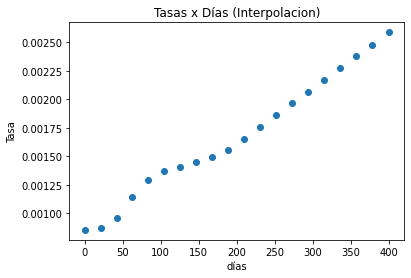

In [8]:
points = 20
tasas = []
days = []

## genera valores 20 valores entre 0 y 400
## np.trunc le saca los decimales
## y va a ir calculando la tasa (interpolada)
## para cada dia y se va a guardar los resultados
for day in np.trunc(np.linspace(0,400,points)):
    days.append(day)
    tasas.append(curva_interp(day))

## plotea dias contra tasas
plt.scatter(days,tasas)
plt.title("Tasas x Días (Interpolacion)")
plt.xlabel("días")
plt.ylabel("Tasa")

In [9]:
## aca vamos a modificar un poco el codigo:

## calcula el promedio entre el bid y el ask y se lo guarda
panel_nyse['Avg'] = (panel_nyse.Bid+panel_nyse.Ask)/2

## se va a quedar con las opciones que les queda Time to maturity y que su volatilidad implicita es > 0.1
panel_nyse = panel_nyse[panel_nyse.TTM>0]
panel_nyse = panel_nyse[panel_nyse.impliedVolatility>0.1]

## reseteamos index
panel_nyse.reset_index(drop=True, inplace=True)


In [10]:
panel_nyse.columns

Index(['Especie', 'Ticker', 'Spot', 'CallPut', 'Strike', 'TTM', 'Last', 'Bid',
       'Ask', 'impliedVolatility', 'Moneyness', 'Div', 'Tasa', 'Avg'],
      dtype='object')

In [11]:
## aplicamos para cada fila el calculo de precio por arbol binomial
## apply va a agarrar cada fila y va a aplicar la funcion opcion_americana_bin 
## con los parametros que le pasamos. Hacemos 200 pasos por arbol
panel_nyse.loc[:,"Precio_BIN"] = panel_nyse.apply(lambda x: opcion_americana_bin(x.CallPut, x.Spot, 
                                                x.Strike, x.TTM/365, x.Tasa, 
                                                x.impliedVolatility, x.Div, 200),1)

In [12]:
## lo mismo con black and scholes
panel_nyse.loc[:,"Precio_BS"] = panel_nyse.apply(lambda x: opcion_europea_bs(x.CallPut, x.Spot, 
                                                x.Strike, x.TTM/365, x.Tasa, 
                                                x.impliedVolatility, x.Div),1)

In [13]:
panel_nyse.head()

,Especie,Ticker,Spot,CallPut,Strike,TTM,Last,Bid,Ask,impliedVolatility,Moneyness,Div,Tasa,Avg,Precio_BIN,Precio_BS
0,TSLA210813C00595000,TSLA,709.98999,C,595.0,3,114.00,114.75,115.75,0.769045,1.193260,0.0,0.000872,115.250,115.073564,115.075827
1,TSLA210813C00600000,TSLA,709.98999,C,600.0,3,110.15,109.65,110.75,0.715823,1.183317,0.0,0.000872,110.200,110.056386,110.057500
2,TSLA210813C00605000,TSLA,709.98999,C,605.0,3,105.32,104.65,105.75,0.684573,1.173537,0.0,0.000872,105.200,105.056674,105.058051
3,TSLA210813C00610000,TSLA,709.98999,C,610.0,3,100.25,99.85,100.80,0.699222,1.163918,0.0,0.000872,100.325,100.106870,100.109650
4,TSLA210813C00615000,TSLA,709.98999,C,615.0,3,96.65,94.70,95.80,0.642093,1.154455,0.0,0.000872,95.250,95.078604,95.079596


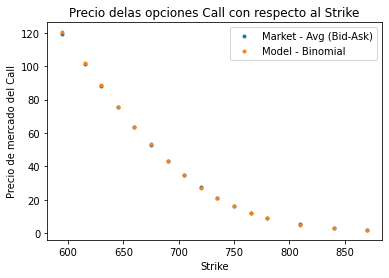

In [14]:
## podemos cambiar CALLS por puts y volver a correr para ver el otro gráfico

## vamos a tomar un TTM cualqueira y vamos a graficar los precios segun arbol y los precios de mercado
TTMs = panel_nyse.TTM.unique() ## tomo los ttm unicos
TTMs.sort() ## los ordenos
TTM = TTMs[4] ## tomo uno cualquiera

## elijo calls (cambiar por "P" para ver puts)
CP = "C"

## subseteo los calls de ese ttm:
df_subset = panel_nyse[(panel_nyse.TTM == TTM) & (panel_nyse.CallPut == CP)]

Ks = df_subset.Strike ## strike
precios_avg = df_subset.Avg ## precio promedio
precios_BS = df_subset.Precio_BS ## black and scholes
precios_BIN = df_subset.Precio_BIN ## arbol binario
    
space = 3

## puedo descomentar y ver otras cosas: vamos a ver ahora el promedio contra el precio segun arbol
#plt.plot(Ks[0::space], precios_last[0::space], '.', label = 'Market - Last')
plt.plot(Ks[0::space], precios_avg[0::space], '.',label = 'Market - Avg (Bid-Ask)')
#plt.plot(Ks[0::space], precios_BS[0::space], '.',label = 'Model - Black Scholes')
plt.plot(Ks[0::space], precios_BIN[0::space], '.',label = 'Model - Binomial')


plt.legend()

plt.xlabel('Strike')
plt.ylabel('Precio de mercado del Call')
plt.title('Precio delas opciones Call con respecto al Strike')
    
plt.show()

In [15]:
#Me genero un dataframe con fiferencias entre mercado y modelos
CP = "C"
## filtro los que tienen un ttm en particular y elijo los calls
## me quedo con precio promedio, precio segun black and scholes y precio de arbol
diff_df = panel_nyse[(panel_nyse.TTM == TTMs[1] ) & (panel_nyse.CallPut == CP)][['Avg','Precio_BS','Precio_BIN']]

## calculo la diferencia entre el promedio y el calculado
diff_df['AvgVSBS'] = diff_df.Avg-diff_df.Precio_BS
diff_df['AvgVSBIN'] = diff_df.Avg-diff_df.Precio_BIN

## y calculo la diferencia porcentual absoluta entre ambos
diff_df['Rel_AvgVSBS'] = abs(diff_df.AvgVSBS)/diff_df.Avg * 100 ## promedio y black and scholes
diff_df['Rel_AvgVSBIN'] = abs(diff_df.AvgVSBIN)/diff_df.Avg * 100 ## promedio y arbol

## se queda con los que tienen un precio promedio mayor a 0
diff_df = diff_df[abs(diff_df.Avg)>0.0]

In [16]:
## podemos ver los promedios de precios y los promedios de diferencias y las diferencias %
diff_df.mean(axis=0)

Avg             35.710795
Precio_BS       35.440995
Precio_BIN      35.440393
AvgVSBS          0.269801
AvgVSBIN         0.270402
Rel_AvgVSBS      8.262758
Rel_AvgVSBIN     8.444220
dtype: float64

In [17]:
### volatilidad implicita

def samesign(a, b):
    ## devuelve True si ambos numeros tienen el mismo signo y False si tienen signo distinto
    return a * b > 0

def bisect(func, low, high, iters=100):
    'Find root of continuous function where f(low) and f(high) have opposite signs'

    ## metodo biseccion
    
    ## el argumento func es una funcion
    ## low y high son los argumentos.
    
    ## chequea que func(low) y func(high) no tengan el mismo signo
    ## si tienen el mismo signo, tira error
    assert not samesign(func(low), func(high))
    
    ## repite "iters" veces 
    for i in range(iters):
        
        ## toma el punto medio entre low y high
        midpoint = (low + high) / 2.0
        
        ## si tienen el mismo signo, ahora low pasa a ser el punto medio
        if samesign(func(low), func(midpoint)):
            low = midpoint
        else:
            ## caso contrario, high pasa a ser el punto medio
            high = midpoint

    return midpoint

In [18]:
# Defino la funcion de volatilidad implicita. 
# Busco el cero de la funcion O_T-O_M (opcion teorica menos opcion mercado)

## la funcion bisect que definimos arriba toma en su primer parámetro (func) una funcion
## así que ahora vamos a usar bisect para calcular volatilidad implícita

def impvolfunc_bs(tipo, S, K, T, r, precio_mercado, div):  
    
    ## define una funcion anonima (este lambda sigma: es como definir una funcion pero en una sola linea)
    ## esta funcion func toma como parámetro "sigma", calcula el precio con black and scholes y le resta
    ## el precio de mercado
    func = lambda sigma: (opcion_europea_bs(tipo, S, K, T, r, sigma, div) - precio_mercado)
    
    ## va a usar la funcion bisect con esta funcion que acaba de definir.
    ## primero evalua en "a" (0.00001) la funcion: calcula el precio segun black and scholes
    ## usando un sigma de 0.00001 y le resta el precio de mercado
    ## despues usa un sigma de 3 y le resta el precio de mercado
    ## se fija que no tengan el mismo signo (o sea que haya quedado el 0 entre ambos)
    ## busca el punto medio entre los dos y repite
    ## la idea es intentar encontrar el 0 (o un numero cerca de 0) de tal manera
    ## que el sigma que te queda es el que hace que el precio calculado sea lo mas parecido al real
    ## (porque la diferencia entre calculado y real es lo mas chica posible)
    impvol = bisect(func,0.00001, 3.0, 100)
    return impvol


def impvolfunc_bin(tipo, S, K, T, r, precio_mercado, div, pasos = 1000):
    func = lambda sigma: (opcion_americana_bin(tipo, S, K, T, r, sigma, div, pasos) - precio_mercado)
    
    ## aca hace lo mismo pero calculando el precio con arbol binario
    impvol = bisect(func,0.0001, 3.0, 100)
    return impvol

In [19]:
## aca cambiamos un poco el codigo 

## vamos a aplicar el calculo de la volatilidad implicita para cada fila de nuestro dataframe
## como precio de mercado usamos el promedio entre bid y ask (Avg)

## aplicamos la funcion impvolfunc_bs a cada fila del dataframe
panel_nyse.loc[:,"volatilidad_implicita_bs"] = panel_nyse.apply(lambda x: impvolfunc_bs(x.CallPut, x.Spot, 
                                                x.Strike, x.TTM/365, x.Tasa, 
                                                x.Avg, x.Div),1)

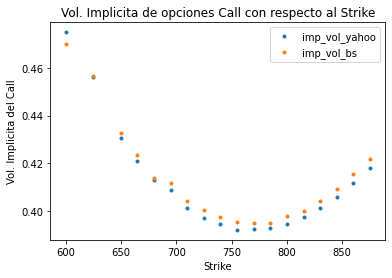

In [20]:
## vamos a graficar un call con alguna ttm (cualquiera)
## podemso cambiar estos valore y ver otros graficos (por ejemplo, CP="P" nos muestra el grafico para un put)
CP = "C"
TTM = TTMs[5]

## subseteamos el tipo de opcion y el ttm
df_subset = panel_nyse[(panel_nyse.TTM == TTM) & (panel_nyse.CallPut == CP)]
Ks = df_subset.Strike
## tomamos la volatilidad implicita que nos trae yahoo
imp_vol_yahoo = df_subset.impliedVolatility

## y la que calculamos nosotros
imp_vol_bs = df_subset.volatilidad_implicita_bs

## voy a tomar cada "space" valores
## en este caso, tomo 1 cada 3 valores
space = 3
    
    
## ploteo volatilidad de yahoo vs la nuestra
#plt.plot(Ks[0::space], precios_last[0::space], '.', label = 'Market - Last')
plt.plot(Ks[0::space], imp_vol_yahoo[0::space], '.',label = 'imp_vol_yahoo')
#plt.plot(Ks[0::space], precios_BS[0::space], '.',label = 'Model - Black Scholes')
plt.plot(Ks[0::space], imp_vol_bs[0::space], '.',label = 'imp_vol_bs')


plt.legend()

plt.xlabel('Strike')
plt.ylabel('Vol. Implicita del Call')
plt.title('Vol. Implicita de opciones Call con respecto al Strike')
    
plt.show()

In [21]:
## griegas
## aca lo que va a hacer es calcular derivadas numericamente

Si llamamos $V$ al derivado en cuestion, y el spot vale $S$ a tiempo inicial, entonces la Delta y la Gamma no son otra cosa que:

$$
\Delta = \frac{V(S+h)-V(S-h)}{2h} \; \; \; \; 
\Gamma = \frac{V(S+h)-2V(S)+V(S-h)}{h^2}
$$

con $h$ un numero sificientemente chico (en general se suele tomar la unidad indivisible en cuestion) y suponemos que todos los demas parametros quedan fijo


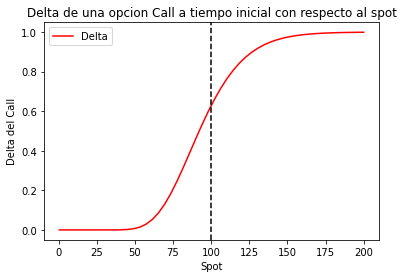

In [22]:
## delta

## defino parámetros (pueden modificarse para ver otros gráficos. Por ejemplo tipo="P" da un put)
tipo = "C"
S = 100
K = 100
T = 1
r = 0.05
sigma= 0.25
div =0
pasos = 1000

## genera precios finales del subyacente: de 0.5 a 2 veces el strike, 50 precios
S_MAX = 2*K
S_vec = np.linspace(0.5,S_MAX,50)      
deltas = np.zeros(len(S_vec)) ## genera un vector de 0 para guardare los deltas

h = 0.1 ## h del denominador

for index in range(len(S_vec)):
    ## calcula el delta. Toma un precio final posible del subyacente y le da un "empujoncito" para cada lado
    ## o sea, le suma y le resta h. Despues hace la diferencia entre ambos y divide por 2h 
    ## (primera formula de mas arriba)
    deltas[index] = (opcion_europea_bs(tipo, S_vec[index]+h, K, T, r, sigma, div) - opcion_europea_bs(tipo, S_vec[index]-h, K, T, r, sigma, div))/(2*h)

## plotea los precios finales posibles de una accion contra el delta
plt.plot(S_vec,deltas,'r', label='Delta')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel(f'Delta del {"Call" if tipo == "C" else "Put"}')
plt.title(f'Delta de una opcion {"Call" if tipo == "C" else "Put"} a tiempo inicial con respecto al spot')

plt.show()

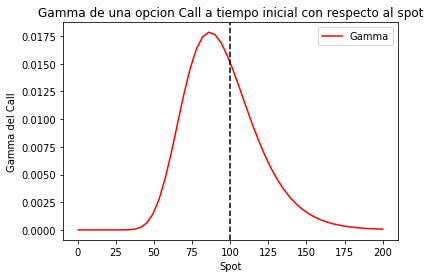

In [23]:
## gamma

## dejo los mismos parámetros que antes
gammas = np.zeros(len(S_vec))

## aca es lo mismo que antes, pero es la formula de la derecha
for index in range(len(S_vec)):
    gammas[index] = (opcion_europea_bs(tipo, S_vec[index]+h, K, T, r, sigma, div) -2* opcion_europea_bs(tipo, S_vec[index], K, T, r, sigma, div) + opcion_europea_bs(tipo, S_vec[index]-h, K, T, r, sigma, div))/(h*h)

plt.plot(S_vec,gammas,'r', label='Gamma')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel(f'Gamma del {"Call" if tipo == "C" else "Put"}')
plt.title(f'Gamma de una opcion {"Call" if tipo == "C" else "Put"} a tiempo inicial con respecto al spot')

plt.show()

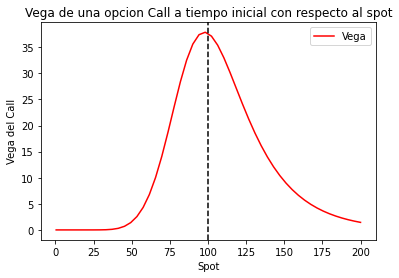

In [24]:
## vega
vegas = np.zeros(len(S_vec))

for index in range(len(S_vec)):
    ## para la vega: calcula el precio con sigma + h
    ## calcula el precio con sigma - h
    ## y divide por h*2
    ## es como delta pero usando sigma en vez del precio
    vegas[index] = (opcion_europea_bs(tipo, S_vec[index], K, T, r, sigma+h, div) - opcion_europea_bs(tipo, S_vec[index], K, T, r, sigma-h, div))/(2*h)

plt.plot(S_vec,vegas,'r', label='Vega')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Vega del Call')
plt.title('Vega de una opcion Call a tiempo inicial con respecto al spot')

plt.show()

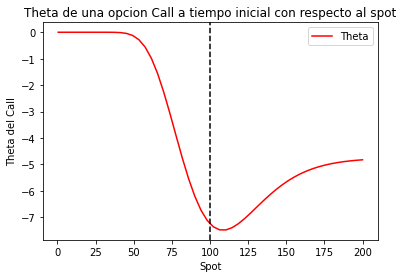

In [25]:
## theta     
thetas = np.zeros(len(S_vec))

## aca h cambia a 1/365
h = 1/365

for index in range(len(S_vec)):
    ## aca calcula como el precio de la opcion con el ttm actual - el precio de la opcion con el ttm+1/365 
    ## y lo divide por h.
    thetas[index] = (opcion_europea_bs(tipo, S_vec[index], K, T, r, sigma, div) - opcion_europea_bs(tipo, S_vec[index], K, T+h, r, sigma, div))/(h)

plt.plot(S_vec,thetas,'r', label='Theta')
plt.axvline(x=S, color = 'black', linestyle='--')

plt.legend()

plt.xlabel('Spot')
plt.ylabel('Theta del Call')
plt.title('Theta de una opcion Call a tiempo inicial con respecto al spot')

plt.show()